In [1]:
!pip install facenet-pytorch --quiet
!pip install --upgrade pillow==6.2.2 

In [2]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import urllib.request
url = 'https://raw.githubusercontent.com/na-nora/face-detection/main/er.png'
image_path = 'er.png'
urllib.request.urlretrieve(url, image_path)

In [3]:
# Load image using OpenCV (BGR)
bgr_img = cv2.imread(image_path)
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(keep_all=True, device=device)

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [6]:
# Detect face bounding boxes
boxes, probs = mtcnn.detect(rgb_img)

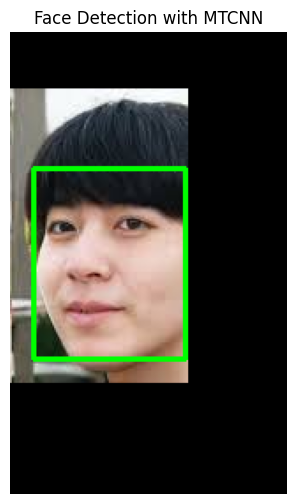

In [7]:
# Draw bounding boxes
def draw_boxes(image, boxes):
    img_copy = image.copy()
    boxes = boxes.tolist() if boxes is not None else []
    for box in boxes or []:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img_copy

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(draw_boxes(rgb_img, boxes))
plt.axis('off')
plt.title("Face Detection with MTCNN")
plt.show()

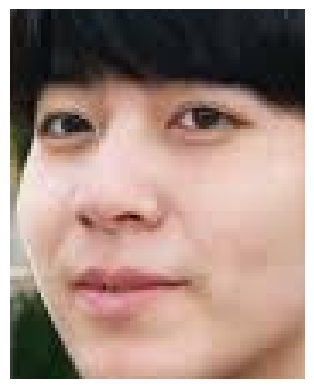

Anzahl erkannter Gesichter: 1


In [8]:
# Show cropped faces

#Cropping
#faces = mtcnn.extract(rgb_img, boxes, save_path=None)
#for i, face in enumerate(faces):
#    face = (face + 1) / 2  # bring Werte von [-1, 1] auf [0, 1]
#    plt.subplot(1, len(faces), i + 1)
#    plt.imshow(face.permute(1, 2, 0).numpy())
#    plt.axis('off')
#plt.show()
# print(f"Anzahl erkannter Gesichter: {len(faces) if faces is not None else 0}")

# Manuelles Cropping der Gesichter basierend auf den Bounding Boxes
faces_original = []
height, width, _ = rgb_img.shape
if boxes is not None and len(boxes) > 0:  # Überprüfen, ob Boxen existieren
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
         # Begrenze die Koordinaten auf gültige Bildbereiche
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)
        face = rgb_img[y1:y2, x1:x2]  # Ausschneiden aus dem Originalbild
        if face.size > 0:  # Überprüfen, ob das Gesicht (Array) nicht leer ist
             faces_original.append(face)
            
for i, face in enumerate(faces_original):
    plt.subplot(1, len(faces_original), i + 1)
    plt.imshow(face)
    plt.axis('off')
plt.show()
            
print(f"Anzahl erkannter Gesichter: {len(faces_original) if faces_original is not None else 0}")

In [9]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # für Facenet [-1, 1] Range
])

embeddings = []
for i, face in enumerate(faces_original):
    face_tensor = transform(face).unsqueeze(0).to(device)  # [1, 3, 160, 160]
    embedding = resnet(face_tensor).detach().cpu().numpy()  # [1, 512]
    embeddings.append(embedding)

    # Optional: abspeichern
    np.save(f'face_{i}_embedding.npy', embedding)

In [11]:
# Bild mit unbekannter Person laden
new_img = cv2.imread("nichtEr.png")  
new_rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)

# Gesicht mit MTCNN finden
new_boxes, _ = mtcnn.detect(new_rgb)

# Gesichter extrahieren, für jedes ein Embedding berechnen und mit gespeicherten Embeddings vergleichen
if new_boxes is not None and len(new_boxes) > 0:
    height, width, _ = new_rgb.shape
    for i, box in enumerate(new_boxes):
        x1, y1, x2, y2 = map(int, box)

        # Sicherstellen, dass Bounding Box innerhalb der Bildgrenzen liegt
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)

        # Gesichter extrahieren (croppen)
        face_crop = new_rgb[y1:y2, x1:x2]

        if face_crop.size > 0:
            # Schritt 4: Vorverarbeitung
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((160, 160)),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])
            face_tensor = transform(face_crop).unsqueeze(0).to(device)


    # Neues Embedding berechnen
    new_embedding = resnet(face_tensor).detach().cpu().numpy()

    # Gespeichertes Embedding laden
    saved_embedding = np.load("face_0_embedding.npy")  # z.B. aus Schritt 1

    # Cosine Similarity berechnen
    similarity = cosine_similarity(new_embedding, saved_embedding)

    # Ergebnis anzeigen
    print(f"Ähnlichkeit: {similarity[0][0]:.4f}")

    if similarity[0][0] > 0.8:
        print("→ Wahrscheinlich dieselbe Person")
    else:
        print("→ Wahrscheinlich verschiedene Personen")
else:
    print("Kein Gesicht im neuen Bild erkannt.")

Ähnlichkeit: -0.0403
→ Wahrscheinlich verschiedene Personen
